<h1 class="title">Jason Scott's favorite 100 - data analysis using NLP</h1>
<h2 class="subtitle">Mini-Project in the ABC of Computational Text Analysis</h2>
<p>Author: <span class="author">Josias Bruderer, Universität Luzern</span></p>
<p>Date: <span class="date">26. May 2021</span></p>

# Preparations [R1]

The following lines of code is used for preparing our environment.

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# load the necessary libraries

import sys
from pathlib import Path
import textacy
import spacy
import re
import itertools
import numpy as np

import scattertext as st 
import pandas as pd

from pathlib import Path
from plotnine import *
import textacy.vsm

project_path = Path.cwd().parent

# prepare to load project specific libraries
module_path = str(project_path / "py/")
if module_path not in sys.path:
    sys.path.append(module_path)

# import data_wrangler module
from modules import data_wrangler
from modules import helpers

# Data Wrangling [R2]

In this section the required data is downloaded and preprocessed (f.E. unzipped). The module data_wrangler will be used for this.

In [2]:
data_url = "http://archives.textfiles.com/100.zip"
data_name = "" #use 100 to only analize the top100 files
data_dir = str(project_path / "data/")
tmp_dir = str(project_path / ".tmp/")

dw = data_wrangler.DataWrangler(tmp_dir, data_dir)

dw.process_zip(data_url, data_name)

# Analisis [R3]

## Preliminary Clarifications [R3.1]

In [3]:
# preparation for manual analisis [R3.1.1]

# read textfiles
dataset = dw.get_texts(data_dir + "/" + data_name)

# write metadata to csv file
f = open("top100_generated.csv", "w+")
for item in dataset:
    f.write(item[1]["name"]+","+
            str(item[1]["length"])+","+
            str(item[1]["length_raw"])+","+
            str(item[1]["avgcolumnsize"])+","+
            str(item[1]["charratioA"])+","+
            str(item[1]["charratioB"])+","+
            str(item[1]["year"])+","+
            str(item[1]["eyear"])+","+
            str(item[1]["lyear"])+","+
            str(item[1]["type"])+","+
            "\r\n")
f.close()

## Create Textcorpora [R3.2]

In [4]:
# read textfiles
dataset = dw.get_texts(data_dir + "/" + data_name)

en = textacy.load_spacy_lang("en_core_web_sm")

# create corpus from processed documents
corpus = textacy.Corpus(en, data=dataset)

## Create Subcorpora [R3.3]

In [5]:
# function to filter by metadata: filter invalid filenames
def filter_by_name(doc):
    return doc._.meta.get("name") != "index.html" and doc._.meta.get("name") != ".ztr-directory"

# function to filter by metadata: filter files that contain less than 50% A-z characters
def filter_by_charratio(doc):
    return doc._.meta.get("charratioA") > 0.5

# create new corpus after applying filter function 
subcorpustemp = textacy.corpus.Corpus(en, data=corpus.get(filter_by_name))
subcorpus = textacy.corpus.Corpus(en, data=subcorpustemp.get(filter_by_charratio))

## Wordcount [R3.4]

In [6]:
# get lowercased and filtered corpus vocabulary (R3.3.1)
vocab = subcorpus.word_counts(as_strings=True, normalize= 'lower', filter_stops = True, filter_punct = True, filter_nums = True)

# sort vocabulary by descending frequency
vocab_sorted = sorted(vocab.items(), key=lambda x: x[1], reverse=True)

# write to file, one word and its frequency per line
fname = './analysis/vocab_frq.txt'
with open(fname, 'w') as f:   
    for word, frq in vocab_sorted:
        line = f"{word}\t{frq}\n"
        f.write(line)

vocab_sorted[:25]

[('computer', 1267),
 ('system', 932),
 ('like', 822),
 ('people', 813),
 ('time', 715),
 ('new', 646),
 ('use', 576),
 ('phone', 555),
 ('program', 554),
 ('number', 537),
 ('t', 501),
 ('real', 497),
 ('software', 492),
 ('service', 489),
 ('know', 468),
 ('bbs', 452),
 ('information', 445),
 ('file', 430),
 ('hackers', 410),
 ('board', 408),
 ('x', 406),
 ('code', 401),
 ('way', 397),
 ('boards', 391),
 ('systems', 390)]

## Export to CSV [R3.5]

In [7]:
# merge metadata and actual content for each document in the corpus
# ugly, verbose syntax to merge two dictionaries
data = [{**doc._.meta, **{'text': doc.text}} for doc in subcorpus]

# export corpus as csv
f_csv = './analysis/subcorpus.csv'
textacy.io.csv.write_csv(data, f_csv, fieldnames=data[0].keys())

## Load CSV file [R3.6]

In [8]:
# read dataset from csv file
f_csv = './analysis/subcorpus.csv'
df = pd.read_csv(f_csv)

df_sub = df[(df['text'].str.len() > 10)]

# make new column containing all relevant metadata (showing in plot later on)
df_sub['descripton'] = df_sub[['name', 'year', 'charratioA', 'avgcolumnsize']].astype(str).agg(', '.join, axis=1)

# sneak peek of dataset
df_sub.head()

,name,length_raw,length,avgcolumnsize,charratioA,charratioB,year,eyear,lyear,type,text,descripton
0,declarationbarlow1996.txt,5089,5089,252.70,4.08,114.66,1996,1996,1996,declaration,A Declaration of the Independence of Cyberspac...,"declarationbarlow1996.txt, 1996, 4.08, 252.7"
1,peat.hum,532,521,56.67,2.13,8.33,nd.,nd.,nd.,textfile,"When we tried to drag her out of the peat, h...","peat.hum, nd., 2.13, 56.67"
2,killsant.hum,3497,3410,57.29,1.60,5.27,1994,1994,1994,textfile,...,"killsant.hum, 1994, 1.6, 57.29"
3,pezrambl.oct,20975,20660,68.49,1.83,9.33,1987-1987,1987,1987,textfile,___ ___ __ ___ __ ___ ...,"pezrambl.oct, 1987-1987, 1.83, 68.49"
4,warning.hum,2537,2492,71.97,1.23,4.46,nd.,nd.,nd.,textfile,...,"warning.hum, nd., 1.23, 71.97"


## Scattertext Plot [R3.7]

In [9]:
# import with a short name
import scattertext as st 
import pandas as pd

# import all specific/all objects from a module
from pathlib import Path
from plotnine import *
import textacy.vsm

censor_tags = set(['CARD']) # tags to ignore in corpus, e.g. numbers

# stop words to ignore in corpus
en_stopwords = spacy.lang.en.stop_words.STOP_WORDS # default stop words
custom_stopwords = set(['[', ']', '%'])
en_stopwords = en_stopwords.union(custom_stopwords) # extend with custom stop words

# create corpus from dataframe
# lowercased terms, no stopwords, no numbers
# use lemmas for English only, German quality is too bad
corpus_speeches = st.CorpusFromPandas(df_sub, # dataset
                             category_col='type', # index differences by ...
                             text_col='text', 
                             nlp=en, # German model
                             feats_from_spacy_doc=st.FeatsFromSpacyDoc(tag_types_to_censor=censor_tags, use_lemmas=True),
                             ).build().get_stoplisted_unigram_corpus(en_stopwords)

# produce visualization (interactive html)
html = st.produce_scattertext_explorer(corpus_speeches,
            category='declaration', # set attribute to divide corpus into two parts
            category_name='declaration',
            not_category_name='textfiles',
            metadata=df_sub['descripton'],
            width_in_pixels=1000,
            minimum_term_frequency=5, # drop terms occurring less than 5 times
            save_svg_button=True,                          
)

# write visualization to html file
fname = "./analysis/viz_declaration_textfiles.html"
open(fname, 'wb').write(html.encode('utf-8'))

4750122

## Docs per Year [R3.8]

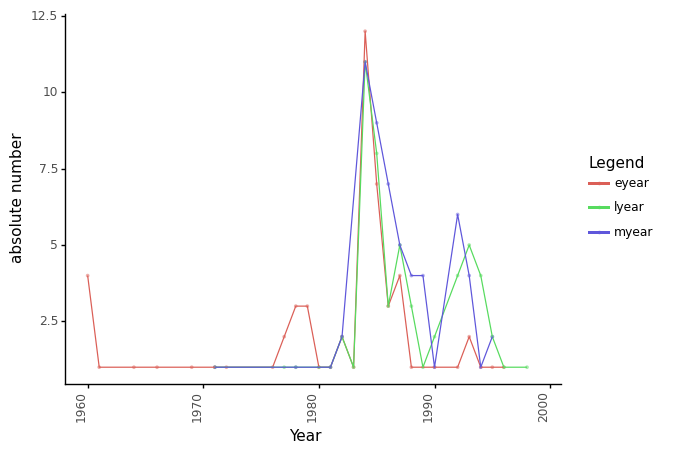

<ggplot: (8737743464162)>

In [10]:
dtmp = df_sub.groupby('eyear').agg({'text': "count" }).reset_index().rename(columns={'text':'count'})
dtmp = dtmp.rename(columns={"eyear": "year"})
dtmp.insert(2,"type","eyear")
docs_per_year = dtmp

dtmp = df_sub.groupby('lyear').agg({'text': "count" }).reset_index().rename(columns={'text':'count'})
dtmp = dtmp.rename(columns={"lyear": "year"})
dtmp.insert(2,"type","lyear")
docs_per_year = docs_per_year.append(dtmp, ignore_index=True)

dtmp = pd.read_csv('top100_years.txt', delimiter = ",").groupby('myear').agg({'text': "count" }).reset_index().rename(columns={'text':'count'})
dtmp = dtmp.rename(columns={"myear": "year"})
dtmp.insert(2,"type","myear")
docs_per_year = docs_per_year.append(dtmp, ignore_index=True)

docs_per_year = docs_per_year[docs_per_year["year"] != "nd."]
docs_per_year['year'] = pd.to_numeric(docs_per_year['year'])

(ggplot(docs_per_year, aes('year', 'count', color='type', group='type'))
 + geom_point(alpha=0.5, stroke = 0)
 + geom_line()
 + theme_classic()
 + labs(x = "Year",
        y = "absolute number",
        color = "Legend")
 + theme(axis_text_x = element_text(angle = 90, hjust = 1))
 + scale_x_continuous(limits = (1960,1999))
)

### Correlations for docs per year

In [11]:
# sorry for ugly...
dummy = pd.DataFrame([{"year":1960, "count": 0},
                     {"year":1961, "count": 0},
                     {"year":1962, "count": 0},
                     {"year":1963, "count": 0},
                     {"year":1964, "count": 0},
                     {"year":1965, "count": 0},
                     {"year":1966, "count": 0},
                     {"year":1967, "count": 0},
                     {"year":1968, "count": 0},
                     {"year":1969, "count": 0},
                     {"year":1970, "count": 0},
                     {"year":1971, "count": 0},
                     {"year":1972, "count": 0},
                     {"year":1973, "count": 0},
                     {"year":1974, "count": 0},
                     {"year":1975, "count": 0},
                     {"year":1976, "count": 0},
                     {"year":1977, "count": 0},
                     {"year":1978, "count": 0},
                     {"year":1979, "count": 0},
                     {"year":1980, "count": 0},
                     {"year":1981, "count": 0},
                     {"year":1982, "count": 0},
                     {"year":1983, "count": 0},
                     {"year":1984, "count": 0},
                     {"year":1985, "count": 0},
                     {"year":1986, "count": 0},
                     {"year":1987, "count": 0},
                     {"year":1988, "count": 0},
                     {"year":1989, "count": 0},
                     {"year":1990, "count": 0},
                     {"year":1991, "count": 0},
                     {"year":1992, "count": 0},
                     {"year":1993, "count": 0},
                     {"year":1994, "count": 0},
                     {"year":1995, "count": 0},
                     {"year":1996, "count": 0},
                     {"year":1997, "count": 0},
                     {"year":1998, "count": 0},
                     {"year":1999, "count": 0}])

m = dummy.append(docs_per_year[docs_per_year['type'] == "myear"][["year","count"]]).groupby('year').agg({'count': "sum" })
e = dummy.append(docs_per_year[docs_per_year['type'] == "eyear"][["year","count"]]).groupby('year').agg({'count': "sum" })
l = dummy.append(docs_per_year[docs_per_year['type'] == "lyear"][["year","count"]]).groupby('year').agg({'count': "sum" })

In [12]:
print("r_{myear mit eyear} = ",np.corrcoef(m["count"], e["count"])[0, 1])
print("r_{myear mit lyear} = ",np.corrcoef(m["count"], l["count"])[0, 1])

r_{myear mit eyear} =  0.7666121890473637
r_{myear mit lyear} =  0.91481657982525


## Entities [R3.9]

In [13]:
entities = []

for doc in subcorpus.docs:
    for ent in textacy.extract.entities(doc):
        try:
            entities += [{"text": ent.text, "label": ent.label_, "explain":spacy.explain(ent.label_)}]
        except:
            print("Problem with:", doc._.meta["name"])

# export corpus as csv
f_csv = './analysis/entities.csv'
textacy.io.csv.write_csv(entities, f_csv, fieldnames=entities[0].keys())

Problem with: top10.news
Problem with: hack11a.txt
Problem with: hack11a.txt
Problem with: hack11a.txt
Problem with: hack11a.txt
Problem with: hack11a.txt
Problem with: famous.bug
Problem with: purity.txt
Problem with: utopia.hum
Problem with: dec.wars
Problem with: dec.wars
Problem with: krckwczt.app


In [14]:
#df_sub.groupby('eyear').agg({'text': "count" }).reset_index().rename(columns={'text':'count'})

df_entities = pd.DataFrame(entities,columns=['text','label','explain'])
df_entities_count = df_entities.groupby('text').agg({'label': "count"}).rename(columns={'label':'count'}).sort_values(by=['count'],ascending=False).reset_index()


# write to file, one word and its frequency per line
fname = './analysis/entities_frq.csv'
with open(fname, 'w') as f:   
    for i, d in df_entities_count.iterrows():
        line = d["text"]+","+str(d["count"])+"\n"
        f.write(line)

df_entities_count[:25]

,text,count
0,one,426
1,first,359
2,two,302
3,1,285
4,2,260
5,3,223
6,10,172
7,24,170
8,IBM,170
9,4,165
